# [Kaggle][Cifar-10] All Convolution

[Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806) was the original paper that were the 2nd place in the Kaggle competition. This kernel was based on the Keras implementation found [here](https://github.com/MateLabs/All-Conv-Keras).

## 1. 關於 Cifar-10 資料集

CIFAR-10 資料集含有 60,000 張 32x32 彩色圖片，分為 10 類，每一類有 6000 張圖片。官方原始資料集的其中 50,000 張用來訓練，10,000 張用來測試。我們有保留原始資料集的訓練/測試分割。我們提供的檔案有：

- train.7z - png 檔案格式的訓練圖片
- test.7z - png 檔案格式的測試圖片
- trainLabels.csv - 訓練圖片的標籤
- sampleSubmission.csv - 提交答案的範例 (id, label)

為了勸阻某些作弊的形式 (例如手動加標籤)，我們在測試圖片集另外添加了 290,000 張垃圾圖片。這些圖片在評分時會被忽略。我們也在官方的 10,000 張測試圖片上，進行了無關緊要的改圖，以防止有人會使用檔案雜湊值來做查找。這些圖片異動應該不會太過影響分數。你應該要對全部 300,000 張測試圖片給出預測標籤。

資料集的圖片分作下列 10 個類別：

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

類別完全沒有重疊。汽車 (automobiles) 和卡車 (trucks) 沒有重疊。汽車 (Automobile) 包含sedans, SUVs, 以及類似的車輛。卡車 (Truck) 只包含大卡車。兩者都不包含小卡車。

## 2. Import Library

In [1]:
import tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, merge
from keras.utils import np_utils
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import os
from PIL import Image

C:\Users\neillee\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 查看是否用到 GPU
tf.test.gpu_device_name()

'/device:GPU:0'

## 3. 資料準備

先使用 Keras 提供的資料集做訓練和驗證，然後再將模型套用到 Kaggle 的測試圖片上

In [3]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

## 4 訓練與驗證資料的預處理

In [4]:
print('train data:', 'images:', X_train.shape, " labels:", y_train.shape)
print('val data:', 'images:', X_val.shape, ' labels:', y_val.shape)

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
val data: images: (10000, 32, 32, 3)  labels: (10000, 1)


In [5]:
# Normalize
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32') / 255.0

In [6]:
# Map to convert between textual labels and numerical classes.
label_to_class = { 'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9 }
class_to_label = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

In [7]:
# One hot encoding
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

## 5. Build model

In [8]:
# Training parameters
batch_size = 32
num_classes = 10
epochs = 350

rows, cols = 32, 32
channels = 3

In [9]:
model = Sequential()

model.add(Conv2D(96, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(96, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(192, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(192, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (1, 1), padding='valid'))
model.add(Activation('relu'))
model.add(Conv2D(10, (1, 1), padding='valid'))

model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

In [34]:
#opt = Adam(lr=0.0001)
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 96)        0         
__________

## 5. Data augmentation

In [30]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) 

datagen.fit(X_train)

## 6. Train

In [45]:
def lr_schedule(epoch, lr):
    lr = 0.01
    if epoch >= 200:
        lr = 0.001
    elif epoch >= 250:
        lr = 0.0001
    elif epoch >= 300:
        lr = 0.00001 
    return lr

best_weights_filepath = 'SavedModel/cifar10-cnn-allconv-best.hdf5'

callbacks = [
    LearningRateScheduler(lr_schedule),
    #EarlyStopping(monitor='val_acc', patience=10),
    ModelCheckpoint(best_weights_filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
]

In [46]:
history = model.fit_generator(datagen.flow(X_train, y_train,
                                           batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(X_val, y_val), 
                              workers=4,
                              verbose=1,
                              callbacks=callbacks)

Epoch 1/350
1563/1563 [==============================] - 463s 296ms/step - loss: 0.3680 - acc: 0.8731 - val_loss: 0.4176 - val_acc: 0.8692

Epoch 00001: val_acc improved from -inf to 0.86920, saving model to SavedModel/cifar10-cnn-allconv-best.hdf5
Epoch 2/350
1563/1563 [==============================] - 471s 301ms/step - loss: 0.3659 - acc: 0.8726 - val_loss: 0.3953 - val_acc: 0.8773

Epoch 00002: val_acc improved from 0.86920 to 0.87730, saving model to SavedModel/cifar10-cnn-allconv-best.hdf5
Epoch 3/350
1563/1563 [==============================] - 475s 304ms/step - loss: 0.3574 - acc: 0.8770 - val_loss: 0.4748 - val_acc: 0.8617

Epoch 00003: val_acc did not improve from 0.87730
Epoch 4/350
1563/1563 [==============================] - 477s 305ms/step - loss: 0.3512 - acc: 0.8770 - val_loss: 0.4273 - val_acc: 0.8709

Epoch 00004: val_acc did not improve from 0.87730
Epoch 5/350
1563/1563 [==============================] - 471s 302ms/step - loss: 0.3523 - acc: 0.8797 - val_loss: 0.424

1563/1563 [==============================] - 447s 286ms/step - loss: 0.2876 - acc: 0.9002 - val_loss: 0.4260 - val_acc: 0.8894

Epoch 00041: val_acc did not improve from 0.89230
Epoch 42/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.2870 - acc: 0.8999 - val_loss: 0.4449 - val_acc: 0.8821

Epoch 00042: val_acc did not improve from 0.89230
Epoch 43/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.2889 - acc: 0.9001 - val_loss: 0.4642 - val_acc: 0.8799

Epoch 00043: val_acc did not improve from 0.89230
Epoch 44/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.2899 - acc: 0.9006 - val_loss: 0.4064 - val_acc: 0.8832

Epoch 00044: val_acc did not improve from 0.89230
Epoch 45/350
1563/1563 [==============================] - 446s 286ms/step - loss: 0.2850 - acc: 0.9007 - val_loss: 0.4734 - val_acc: 0.8750

Epoch 00045: val_acc did not improve from 0.89230
Epoch 46/350
1563/1563 [==============================] - 


Epoch 00082: val_acc did not improve from 0.89550
Epoch 83/350
1563/1563 [==============================] - 446s 286ms/step - loss: 0.2805 - acc: 0.9036 - val_loss: 0.4327 - val_acc: 0.8895

Epoch 00083: val_acc did not improve from 0.89550
Epoch 84/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.2755 - acc: 0.9058 - val_loss: 0.4411 - val_acc: 0.8893

Epoch 00084: val_acc did not improve from 0.89550
Epoch 85/350
1563/1563 [==============================] - 446s 286ms/step - loss: 0.2745 - acc: 0.9066 - val_loss: 0.4343 - val_acc: 0.8857

Epoch 00085: val_acc did not improve from 0.89550
Epoch 86/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.2768 - acc: 0.9055 - val_loss: 0.4912 - val_acc: 0.8849

Epoch 00086: val_acc did not improve from 0.89550
Epoch 87/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.2727 - acc: 0.9057 - val_loss: 0.5316 - val_acc: 0.8740

Epoch 00087: val_acc did not improve from 0.

1563/1563 [==============================] - 446s 286ms/step - loss: 0.2866 - acc: 0.9022 - val_loss: 0.5051 - val_acc: 0.8834

Epoch 00125: val_acc did not improve from 0.90120
Epoch 126/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.2890 - acc: 0.9028 - val_loss: 0.4856 - val_acc: 0.8811

Epoch 00126: val_acc did not improve from 0.90120
Epoch 127/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.2922 - acc: 0.9013 - val_loss: 0.4570 - val_acc: 0.8843

Epoch 00127: val_acc did not improve from 0.90120
Epoch 128/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.2837 - acc: 0.9036 - val_loss: 0.4895 - val_acc: 0.8902

Epoch 00128: val_acc did not improve from 0.90120
Epoch 129/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.2888 - acc: 0.9034 - val_loss: 0.4731 - val_acc: 0.8878

Epoch 00129: val_acc did not improve from 0.90120
Epoch 130/350
1563/1563 [=============================

1563/1563 [==============================] - 447s 286ms/step - loss: 0.2956 - acc: 0.9013 - val_loss: 0.4440 - val_acc: 0.8970

Epoch 00168: val_acc did not improve from 0.90120
Epoch 169/350
1563/1563 [==============================] - 445s 285ms/step - loss: 0.2970 - acc: 0.8996 - val_loss: 0.5074 - val_acc: 0.8829

Epoch 00169: val_acc did not improve from 0.90120
Epoch 170/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.3032 - acc: 0.8979 - val_loss: 0.4920 - val_acc: 0.8875

Epoch 00170: val_acc did not improve from 0.90120
Epoch 171/350
1563/1563 [==============================] - 447s 286ms/step - loss: 0.2978 - acc: 0.8996 - val_loss: 0.4574 - val_acc: 0.8881

Epoch 00171: val_acc did not improve from 0.90120
Epoch 172/350
1563/1563 [==============================] - 446s 286ms/step - loss: 0.3043 - acc: 0.8985 - val_loss: 0.4716 - val_acc: 0.8869

Epoch 00172: val_acc did not improve from 0.90120
Epoch 173/350
1563/1563 [=============================

1563/1563 [==============================] - 446s 285ms/step - loss: 0.1607 - acc: 0.9446 - val_loss: 0.3948 - val_acc: 0.9158

Epoch 00209: val_acc improved from 0.91380 to 0.91580, saving model to SavedModel/cifar10-cnn-allconv-best.hdf5
Epoch 210/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1593 - acc: 0.9450 - val_loss: 0.4110 - val_acc: 0.9111

Epoch 00210: val_acc did not improve from 0.91580
Epoch 211/350
1563/1563 [==============================] - 445s 285ms/step - loss: 0.1586 - acc: 0.9457 - val_loss: 0.4027 - val_acc: 0.9144

Epoch 00211: val_acc did not improve from 0.91580
Epoch 212/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1520 - acc: 0.9473 - val_loss: 0.3978 - val_acc: 0.9158

Epoch 00212: val_acc did not improve from 0.91580
Epoch 213/350
1563/1563 [==============================] - 446s 286ms/step - loss: 0.1572 - acc: 0.9466 - val_loss: 0.3930 - val_acc: 0.9154

Epoch 00213: val_acc did not improve from 

1563/1563 [==============================] - 446s 285ms/step - loss: 0.1218 - acc: 0.9571 - val_loss: 0.3946 - val_acc: 0.9193

Epoch 00249: val_acc did not improve from 0.92020
Epoch 250/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1206 - acc: 0.9582 - val_loss: 0.3989 - val_acc: 0.9185

Epoch 00250: val_acc did not improve from 0.92020
Epoch 251/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1189 - acc: 0.9584 - val_loss: 0.3964 - val_acc: 0.9201

Epoch 00251: val_acc did not improve from 0.92020
Epoch 252/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1189 - acc: 0.9580 - val_loss: 0.4159 - val_acc: 0.9163

Epoch 00252: val_acc did not improve from 0.92020
Epoch 253/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1167 - acc: 0.9605 - val_loss: 0.3954 - val_acc: 0.9176

Epoch 00253: val_acc did not improve from 0.92020
Epoch 254/350
1563/1563 [=============================

1563/1563 [==============================] - 446s 285ms/step - loss: 0.1032 - acc: 0.9639 - val_loss: 0.4249 - val_acc: 0.9174

Epoch 00291: val_acc did not improve from 0.92270
Epoch 292/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1001 - acc: 0.9650 - val_loss: 0.4148 - val_acc: 0.9187

Epoch 00292: val_acc did not improve from 0.92270
Epoch 293/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1028 - acc: 0.9634 - val_loss: 0.4291 - val_acc: 0.9188

Epoch 00293: val_acc did not improve from 0.92270
Epoch 294/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1031 - acc: 0.9645 - val_loss: 0.4042 - val_acc: 0.9201

Epoch 00294: val_acc did not improve from 0.92270
Epoch 295/350
1563/1563 [==============================] - 446s 285ms/step - loss: 0.1038 - acc: 0.9636 - val_loss: 0.4215 - val_acc: 0.9186

Epoch 00295: val_acc did not improve from 0.92270
Epoch 296/350
1563/1563 [=============================

1563/1563 [==============================] - 478s 306ms/step - loss: 0.0958 - acc: 0.9663 - val_loss: 0.4275 - val_acc: 0.9187

Epoch 00334: val_acc did not improve from 0.92270
Epoch 335/350
1563/1563 [==============================] - 478s 306ms/step - loss: 0.0936 - acc: 0.9679 - val_loss: 0.4044 - val_acc: 0.9193

Epoch 00335: val_acc did not improve from 0.92270
Epoch 336/350
1563/1563 [==============================] - 481s 308ms/step - loss: 0.0958 - acc: 0.9663 - val_loss: 0.4172 - val_acc: 0.9190

Epoch 00336: val_acc did not improve from 0.92270
Epoch 337/350
1563/1563 [==============================] - 481s 308ms/step - loss: 0.0910 - acc: 0.9685 - val_loss: 0.4137 - val_acc: 0.9211

Epoch 00337: val_acc did not improve from 0.92270
Epoch 338/350
1563/1563 [==============================] - 475s 304ms/step - loss: 0.0926 - acc: 0.9670 - val_loss: 0.4406 - val_acc: 0.9190

Epoch 00338: val_acc did not improve from 0.92270
Epoch 339/350
1563/1563 [=============================

In [47]:
# Score trained model.
scores = model.evaluate(X_val, y_val, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

10000/10000 [==============================] - 30s 3ms/step
Val loss: 0.42060791709460316
Val accuracy: 0.9185


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_train_history(train_history, y_label = 'Accuracy', train_metric = 'acc', val_metric = 'val_acc'):
    # plot training history
    plt.plot(history.history[train_metric])
    plt.plot(history.history[val_metric])
    plt.title('Training history')
    plt.ylabel(y_label)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

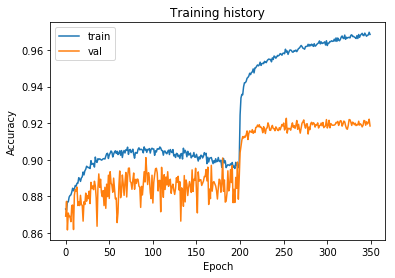

In [49]:
show_train_history(history)

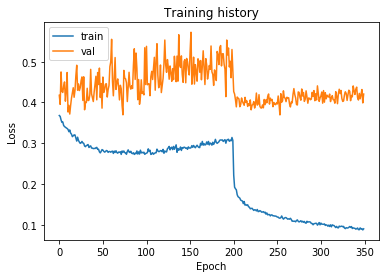

In [50]:
show_train_history(history, y_label = 'Loss', train_metric = 'loss', val_metric = 'val_loss')

## 7. Save Weight to h5

In [51]:
score = model.evaluate(X_val, y_val, verbose=0)[1]
score

0.9185

In [52]:
filename = 'SavedModel/cifar10-cnn-allconv-{}.h5'.format(score)
model.save_weights(filename)
print('Saved model weights to ' + filename)

Saved model weights to SavedModel/cifar10-cnn-allconv-0.9185.h5


## 8. Predict

In [53]:
model.load_weights(best_weights_filepath)

In [22]:
test_dir = 'input/test'
test_ids = list(range(1, 300001))

In [23]:
X_test = np.array([np.array(Image.open(test_dir + '/' + str(test_id) + '.png' )) for test_id in test_ids])

In [24]:
X_test = X_test.astype('float32') / 255.0

In [54]:
prediction = model.predict_classes(X_test)

In [55]:
labels = [ class_to_label[prediction[i]] for i in range(len(prediction))]

# 9. Submit

In [56]:
df_submission = pd.DataFrame(data = { 'id': test_ids, 'label': labels }, columns = [ 'id', 'label' ])

In [57]:
df_submission.to_csv('output/submission-{}.csv'.format(score), index=False)